In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import requests
import json

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from statsmodels.formula.api import logit

# utilities
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, auc
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
import datetime 

#customizations
plt.style.use('ggplot')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (18, 8)
plt.rcParams['text.color'] = 'k'

In [42]:
df1 = pd.read_csv('takehome_user_engagement.csv')
df1.time_stamp = pd.to_datetime(df1.time_stamp)

df2 = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [57]:
df1_new = df1.groupby(['user_id']).agg(unique_login_days=('visited', 'count')).reset_index()
df1_new['adopted_user'] = df1_new['unique_login_days'].apply(lambda x: 1 if x>=3 else 0)
df1_new.head()

,user_id,unique_login_days,adopted_user
0,1,1,0
1,2,14,1
2,3,1,0
3,4,1,0
4,5,1,0


In [197]:
# Joining both tables
df_all = pd.merge(df2, df1_new, left_on='object_id', right_on='user_id', how='inner')

In [198]:
df_all.invited_by_user_id = df_all.invited_by_user_id.fillna('0.0')

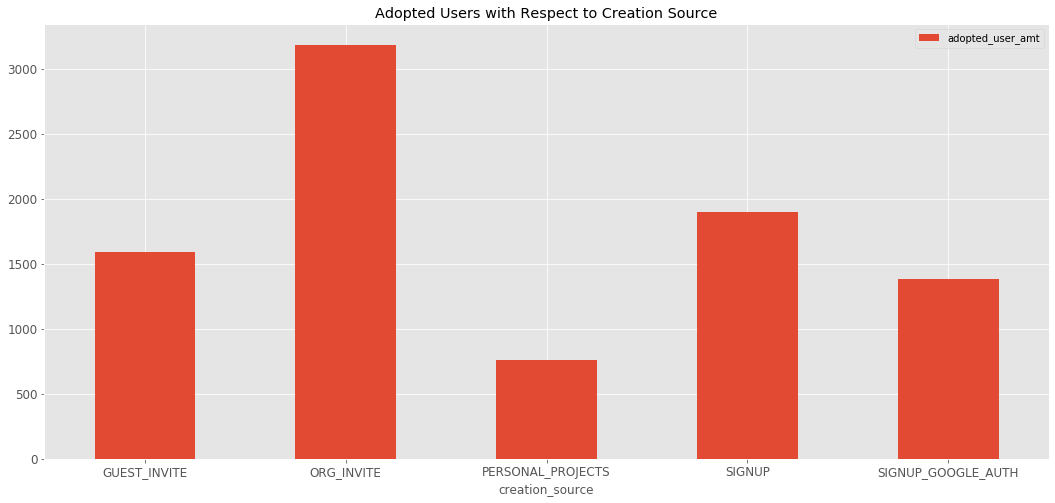

In [201]:
df_all.groupby('creation_source').agg(adopted_user_amt=('adopted_user', 'count')).plot(kind='bar')
plt.title('Adopted Users with Respect to Creation Source')
plt.xticks(rotation=0);

# Preprocessing

In [189]:
# Creating new feature for the email provider from the email
df_all['email_provider'] = df_all.email.str.split('@').str[1].str.split('.').str[0]
top_emails = df_all.email_provider.value_counts()[:6].index
df_all['email_provider'] = df_all['email_provider'].apply(lambda x: x if x in top_emails else 'other')

#dropping irrelevant columns
df_all = df_all.drop(['object_id', 'name', 'user_id', 
                      'unique_login_days', 'invited_by_user_id', 
                      'creation_time', 'email'], axis='columns')


In [190]:
# Encoding string features and recombining the dataframes
str_cols = df_all.columns[df_all.dtypes == 'object']
df_all_str = pd.get_dummies(df_all[str_cols], drop_first=True)
df_all = df_all.drop(str_cols, axis='columns')

In [191]:
df_all = df_all.join(df_all_str)

# Modeling

In [192]:
X = df_all.drop(['adopted_user'], axis='columns')
y = df_all.adopted_user

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [193]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Z:\Users\Don\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [194]:
pd.DataFrame(list(zip(df_all.columns, model.feature_importances_)), columns=['Feature', 'Variable Importance']).sort_values(by='Variable Importance', ascending=False)

,Feature,Variable Importance
0,last_session_creation_time,0.636915
3,org_id,0.278290
1,opted_in_to_mailing_list,0.013034
2,enabled_for_marketing_drip,0.012151
4,adopted_user,0.008725
10,email_provider_gustr,0.007149
8,creation_source_SIGNUP_GOOGLE_AUTH,0.006895
6,creation_source_PERSONAL_PROJECTS,0.006502
9,email_provider_gmail,0.006061
13,email_provider_other,0.005985


In [195]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88      2166
           1       0.72      0.49      0.58       746

    accuracy                           0.82      2912
   macro avg       0.78      0.71      0.73      2912
weighted avg       0.81      0.82      0.81      2912

